In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from abc import abstractmethod
import numpy as np
from fractalart.core import Image
import math
import matplotlib.pyplot as plt
from enum import IntEnum
import numba
from numba import njit, prange
from numba.experimental import jitclass
from numba.typed import List

In [4]:
class Fractal(Image):
    """Abstract base class for generating fractal images."""

    def __init__(
        self,
        width: int = 800,
        height: int = 800,
        x_min: float = -2.0,
        x_max: float = 1.0,
        y_min: float = -1.5,
        y_max: float = 1.5,
        max_iter: int = 1000,
    ):
        """Initialize the fractal with image resolution and complex plane bounds."""
        super().__init__(width, height)
        self._x_min, self._x_max = x_min, x_max
        self._y_min, self._y_max = y_min, y_max
        self._max_iter = max_iter  # Uses property setter for validation
        self._orbit_trap_strategies = List.empty_list(Strategy.class_type.instance_type)

    @abstractmethod
    def compute(self) -> np.ndarray:
        """Abstract method to compute the fractal array. Must be implemented by subclasses."""
        pass

    @property
    def max_iter(self) -> int:
        """Maximum number of iterations used in fractal computation."""
        return self._max_iter

    @max_iter.setter
    def max_iter(self, value: int):
        if value <= 0:
            raise ValueError("max_iter must be a positive integer.")
        self._max_iter = value

    def addOrbitTrapStrategy(self, trap_type):
        self._orbit_trap_strategies.append(Strategy(trap_type, self._image.copy()))

    def plot(self, cmap: str = "turbo"):
        """Display the rendered fractal image using matplotlib."""
        # TODO : Us lighter image plotting, e. g. using PIL.Image or cv2
        plt.figure(figsize=(8, 8))
        plt.imshow(
            self._image,
            cmap=cmap,
            extent=[self._x_min, self._x_max, self._y_min, self._y_max],
            origin='lower'
        )
        plt.axis('off')
        plt.show()
    
    def set_zoom(self, zoom: float, center: tuple[float, float]):
        """
        Zoom into the fractal at a specific center.

        Args:
            zoom: Zoom factor (higher is closer).
            center: (x, y) center coordinates in the complex plane.
        """
        if zoom <= 0:
            raise ValueError("zoom must be a positive number.")
        delta = 2 / zoom
        cx, cy = center
        self._x_min, self._x_max = cx - delta, cx + delta
        self._y_min, self._y_max = cy - delta, cy + delta

    def _render(self):
        """Generate and store the fractal image using the subclass-defined `compute` method."""
        self._image = self.compute()

In [5]:
#@njit(parallel=True, fastmath=True)
#def _compute_mandelbrot_set(x_min: float, x_max: float, y_min: float, y_max: float, width: int, height: int, max_iter: int) -> np.ndarray:
#    # Allocate with float32 to halve memory bandwidth (optional)
#    result = np.zeros((height, width), dtype=np.float32)
#    #cross_trap = np.zeros((height, width), dtype=np.float32)
#
#    dx = (x_max - x_min) / (width - 1)
#    dy = (y_max - y_min) / (height - 1)
#
#    inv_log2 = 1.0 / math.log(2.0)   # for nu calculation
#    r2_cut = max(abs(x_max), abs(x_min)) * max(abs(x_max), abs(x_min)) + max(abs(y_max), abs(y_min)) * max(abs(y_max), abs(y_min))
#
#    for j in prange(height):
#        zy = y_min + j * dy
#        for i in range(width):
#            zx = x_min + i * dx
#            zr = 0.0
#            zi = 0.0
#            cr = zx
#            ci = zy
#            iteration = 0
#            escaped = False
#            #min_cross = 1e10
#
#            # Mandelbrot iteration
#            while zr * zr + zi * zi <= r2_cut and iteration < max_iter:
#                # TODO : use zr * zr + zi * zi <= 4 and iteration < max_iter for classical fractal calculation without orbit traps
#                # (zr + i zi)^2 + c
#                zr2 = zr * zr - zi * zi + cr
#                zi = 2.0 * zr * zi + ci
#                zr = zr2
#                iteration += 1
#                    
#                # Cross trap: distance to real or imaginary axis
#                # TOTO : only take the min after a specific number of iterations , e. g. iteration > 3:
#                #if iteration > 2:
#                #    cross_dist = min(abs(zr), abs(zi))
#                #    if (cross_dist < min_cross):
#                #        min_cross = cross_dist
#    
#            if iteration < max_iter:
#                # smooth coloring
#                mag_sq = zr * zr + zi * zi
#                log_zn = 0.5 * math.log(mag_sq)
#                nu = math.log(log_zn * inv_log2) * inv_log2
#                result[j, i] = iteration + 1 - nu
#            else:
#                result[j, i] = iteration
#
#            #cross_trap[j, i] = min_cross
#
#    return result
#    #return cross_trap
#
#class Mandelbrot(Fractal):
#    def compute(self) -> np.ndarray:
#        w, h = self.resolution
#        # pass resolution-consistent dims
#        return _compute_mandelbrot_set(self._x_min, self._x_max, self._y_min, self._y_max, w, h, self._max_iter)

In [6]:
#m = Mandelbrot()
#m.resolution = 1200, 1200
#m.max_iter = 3000
#m.render()
#m.equalize_histogram()
#m.plot()

In [13]:
@njit(parallel=True, fastmath=True)
def _compute_mandelbrot_set(x_min: float, x_max: float, y_min: float, y_max: float, width: int, height: int, max_iter: int, strategies) -> np.ndarray:
    # Allocate with float32 to halve memory bandwidth (optional)
    result = np.zeros((height, width), dtype=np.float32)
    #cross_trap = np.zeros((height, width), dtype=np.float32)

    dx = (x_max - x_min) / (width - 1)
    dy = (y_max - y_min) / (height - 1)

    inv_log2 = 1.0 / math.log(2.0)   # for nu calculation
    r2_cut = max(abs(x_max), abs(x_min)) * max(abs(x_max), abs(x_min)) + max(abs(y_max), abs(y_min)) * max(abs(y_max), abs(y_min))

    for j in prange(height):
        zy = y_min + j * dy
        for i in range(width):
            zx = x_min + i * dx
            zr = 0.0
            zi = 0.0
            cr = zx
            ci = zy
            iteration = 0
            escaped = False
            #min_cross = 1e10

            # Mandelbrot iteration
            while iteration < max_iter:                        
                ns = len(strategies)
                for s in range(ns):
                    strategies[s].apply(zr, zi, i, j, iteration)
                
                # TODO : use zr * zr + zi * zi <= 4 and iteration < max_iter for classical fractal calculation without orbit traps
                # (zr + i zi)^2 + c
                zr2 = zr * zr - zi * zi + cr
                zi = 2.0 * zr * zi + ci
                zr = zr2
                iteration += 1

                if not escaped:
                    mag_sq = zr * zr + zi * zi
                    if mag_sq > r2_cut:
                        escaped = True
                        log_zn = 0.5 * math.log(mag_sq)
                        nu = math.log(log_zn * inv_log2) * inv_log2
                        result[j, i] = iteration + 1 - nu

                # Cross trap: distance to real or imaginary axis
                # TOTO : only take the min after a specific number of iterations , e. g. iteration > 3:
                #if iteration > 2:
                #    cross_dist = min(abs(zr), abs(zi))
                #    if (cross_dist < min_cross):
                #        min_cross = cross_dist

            if not escaped:
                result[j, i] = iteration

    return result
    #return cross_trap

class Mandelbrot(Fractal):
    def compute(self) -> np.ndarray:
        w, h = self.resolution
        strategies = List(self._orbit_trap_strategies)
        # pass resolution-consistent dims
        return _compute_mandelbrot_set(self._x_min, self._x_max, self._y_min, self._y_max, w, h, self._max_iter, strategies)

In [14]:
m = Mandelbrot()
m.resolution = 1200, 1200
m.max_iter = 3000
m.render()
m.equalize_histogram()
m.plot()

TypeError: invalid operation on untyped list

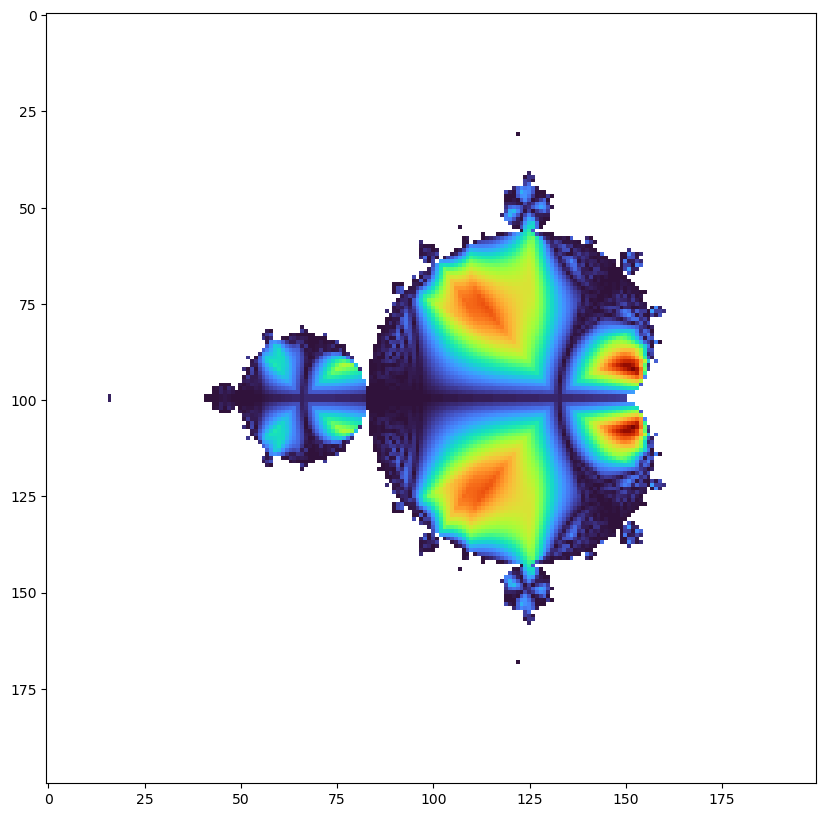

In [16]:
class OrbitTrapStrategyType(IntEnum):
    CROSS_TRAP = 0

spec = [
    ('_trap_type', numba.types.int32),
     ('_trap_image', numba.types.float32[:, :])]

@jitclass(spec)
class Strategy:
    def __init__(self, trap_type, trap_image):
        self._trap_type = trap_type
        self._trap_image = trap_image
        self._trap_image[:] = 1e10

    def apply(self, zr, zi, i, j, iteration):
        if self._trap_type == OrbitTrapStrategyType.CROSS_TRAP:
            if iteration > 2:
               return trap_dist = min(abs(zr), abs(zi))
               if (trap_dist < self._trap_image[j, i]):
                   self._trap_image[j, i] = trap_dist

@njit
def apply_all(strategies, zr, zi, i, j, iteration):
    n = len(strategies)
    out = np.empty(n, dtype=np.float64)
    for i in range(n):
        val = strategies[i].apply(zr, zi, i, j, iteration)

# Usage
m = Mandelbrot()
m.resolution = 200, 200
m.max_iter = 1000
m.addOrbitTrapStrategy(OrbitTrapStrategyType.CROSS_TRAP)
m.render()
m.equalize_histogram()
#m.plot()


plt.figure(figsize=(10, 10))
plt.imshow(m._orbit_trap_strategies[0]._trap_image, cmap="turbo")
plt.axis('on')
plt.show()

#arr = np.zeros((height, width), dtype=np.float32)
#strats = List()
#strats.append(Strategy(OrbitTrapStrategyType.CROSS_TRAP, arr))
#strats.append(Strategy(OrbitTrapStrategyType.DOUBLE, arr))
#strats.append(Strategy(OrbitTrapStrategyType.SQUARE, arr))
#
#apply_all(strats, 3.0)
#print(result)
#print([s.result for s in strats])


In [ ]:
m = Mandelbrot()
m.resolution = 1200, 1200
m.max_iter = 3000

#m.set_zoom(5, (-0.170337,-1.06506))
#m.set_zoom(25, (-0.170337,-1.06506))
#m.set_zoom(125, (-0.170337,-1.06506))
#m.set_zoom(625, (-0.170337,-1.06506))
#m.set_zoom(3125, (-0.170337,-1.06506))
#m.set_zoom(15625, (-0.170337,-1.06506))
#m.set_zoom(78125, (-0.170337,-1.06506))

#m.set_zoom(5, (0.42884,-0.231345))
#m.set_zoom(25, (0.42884,-0.231345))
m.set_zoom(125, (0.42884,-0.231345))
#m.set_zoom(625, (0.42884,-0.231345))
#m.set_zoom(3125, (0.42884,-0.231345))
#m.set_zoom(15625, (0.42884,-0.231345))
#m.set_zoom(78125, (0.42884,-0.231345))

#m.set_zoom(5, (-1.62917,-0.0203968))
#m.set_zoom(25, (-1.62917,-0.0203968))
#m.set_zoom(125, (-1.62917,-0.0203968))
#m.set_zoom(625, (-1.62917,-0.0203968))
#m.set_zoom(3125, (-1.62917,-0.0203968))
#m.set_zoom(15625, (-1.62917,-0.0203968))
#m.set_zoom(78125, (-1.62917,-0.0203968))

#m.set_zoom(5, (-0.761574,-0.0847596))
#m.set_zoom(25, (-0.761574,-0.0847596))
#m.set_zoom(125, (-0.761574,-0.0847596))
#m.set_zoom(625, (-0.761574,-0.0847596))
#m.set_zoom(3125, (-0.761574,-0.0847596))
#m.set_zoom(15625, (-0.761574,-0.0847596))
#m.set_zoom(78125, (-0.761574,-0.0847596))

m.render()
#m.equalize_histogram()
m.plot()